# Limpieza de datos #
### Data Cleaning

Importamos las **librerías** que van a ser necesarias para el desarrollo de las pertinentes acciones en este notebook.

In [1]:
import warnings
warnings.simplefilter("ignore")

from graphviz import Source
from IPython.display import Image
from pandas import Series, DataFrame
from scipy.interpolate import interp1d
from scipy.stats import*
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import tree, datasets, svm
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import ast
import calendar
import csv
import geocoder
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydot
import pydotplus
import reverse_geocoder as rg
import scipy.fftpack
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import time

Se especifican configuraciones sobre los displays de tablas e inicializamos un contador de tiempo para medición de performance.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
inicio = time.strftime("%c")
%matplotlib inline

Cargamos en jupyter el dataset importado desde **kaggle**. Además para ver una pequeña aproximación de los datos que tenemos para comenzar a su limpieza, generamos un pequeño resumen con el tipo de datos y si es un tipo **Null** o **NaN**.

In [3]:
df_ori = pd.read_csv(".././DataOrigen/database.csv", low_memory=False)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477732 entries, 0 to 477731
Data columns (total 29 columns):
UNIQUE KEY             477732 non-null int64
DATE                   477732 non-null object
TIME                   477732 non-null object
BOROUGH                338390 non-null object
ZIP CODE               338329 non-null float64
LATITUDE               356600 non-null float64
LONGITUDE              356600 non-null float64
LOCATION               356600 non-null object
ON STREET NAME         364552 non-null object
CROSS STREET NAME      335574 non-null object
OFF STREET NAME        58511 non-null object
PERSONS INJURED        477732 non-null int64
PERSONS KILLED         477732 non-null int64
PEDESTRIANS INJURED    477732 non-null int64
PEDESTRIANS KILLED     477732 non-null int64
CYCLISTS INJURED       477732 non-null int64
CYCLISTS KILLED        477732 non-null int64
MOTORISTS INJURED      477732 non-null int64
MOTORISTS KILLED       477732 non-null int64
VEHICLE 1 TYPE        

Como técnica de normalización, renombramos las columnas del dataset por su traducción en **español**.

In [4]:
df_temp = df_ori.copy()
df_temp.columns = ['ID','FECHA','TIEMPO','AREA','CODIGO_POSTAL','LATITUD','LONGITUD','LOCALIZACION','CALLE1','CALLE2','CALLE3','PERSONA_LESIONADA','PERSONA_MUERTA','PEATON_LESIONADO','PEATON_MUERTO','CICLISTA_LESIONADO','CICLISTA_MUERTO','MOTORISTA_LESIONADO','MOTORISTA_MUERTO','VEHICULO1','VEHICULO2','VEHICULO3','VEHICULO4','VEHICULO5','FACTOR1','FACTOR2','FACTOR3','FACTOR4','FACTOR5']
df_temp.columns

Index(['ID', 'FECHA', 'TIEMPO', 'AREA', 'CODIGO_POSTAL', 'LATITUD', 'LONGITUD',
       'LOCALIZACION', 'CALLE1', 'CALLE2', 'CALLE3', 'PERSONA_LESIONADA',
       'PERSONA_MUERTA', 'PEATON_LESIONADO', 'PEATON_MUERTO',
       'CICLISTA_LESIONADO', 'CICLISTA_MUERTO', 'MOTORISTA_LESIONADO',
       'MOTORISTA_MUERTO', 'VEHICULO1', 'VEHICULO2', 'VEHICULO3', 'VEHICULO4',
       'VEHICULO5', 'FACTOR1', 'FACTOR2', 'FACTOR3', 'FACTOR4', 'FACTOR5'],
      dtype='object')

Vamos a hacer una aproximación gráfica acerca de el contenido de valos **NaN** en cada campo

In [5]:
porcentaje_VP = ((1-df_temp.count(axis=0)/len((df_temp)))*100)

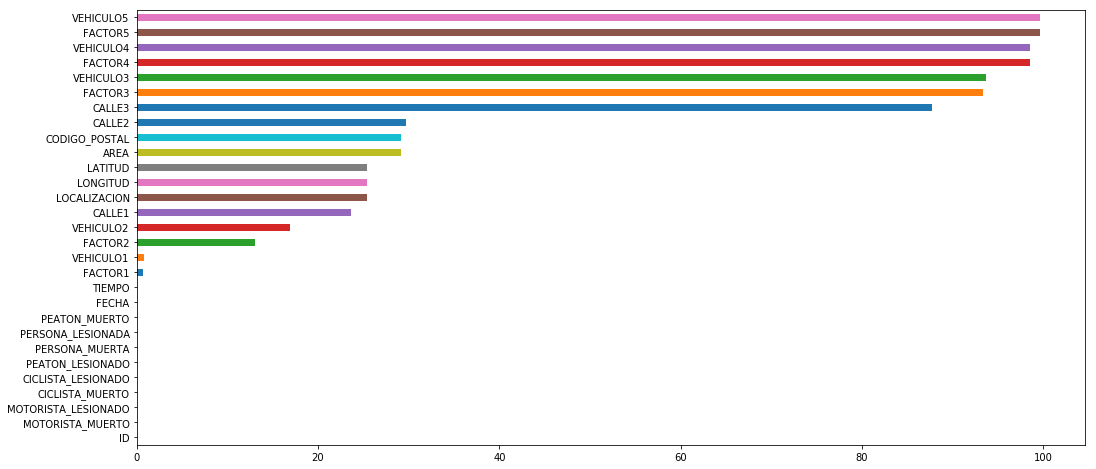

In [6]:
graf_porcentaje_VP = porcentaje_VP.sort_values(ascending = True).plot(kind='barh')
graf_porcentaje_VP.get_figure().set_size_inches(17, 8)
plt.savefig('.././Imagenes/LD/LD_IMAGEN1.png', bbox_inches='tight')
plt.show()

Tras un primer acercamiento sobre el contenido real de cada columna, podemos cerciorarnos de que disponemos de hasta 7 campos cuyo contenido supera el 85% de valores nulos. 
El preprocesamiento de estos valores podría incurrir en datos falsos y conclusiones erroneas, por lo que optamos por eliminarlos para el análisis exploratorio de los datos(**EDA**).

Como columnas importantes para el TFM, hemos visualizado las columnas **`AREA`**, **`LATITUD`**, **`LONGITUD`**, ya que van a formar parte de datos categóricos en la mayoría de análisis exploratorios como en la generación de los los algoritmos.

El primer proceso de limpieza, va a hacer uso de la librería **geocoder** para que a través de las coordenadas se pueda averiguar el área o distrito.

1. Filtramos el dataframe original con los datos que necesitamos.
2. Volvemos a filtrar ya con este dataframe aquellos registros cuya columna **`AREA`** no esté rellena.
3. A través de la librería descrita anteriormente generaremos un archivo con **`LATITUD`**, **`LONGITUD`**, **`AREA`**.

In [7]:
df_geo=df_temp[['LATITUD','LONGITUD','LOCALIZACION','AREA']].copy()
df_geo=df_geo[pd.isnull(df_temp['AREA'])].dropna(subset=['LOCALIZACION'])
valu,rows = [],[]
for x in df_geo['LOCALIZACION'].values:
    val = x.strip(',')
    valu.append(val)
    geo_coor = list(ast.literal_eval(','.join(valu)))
geo_var = rg.search(geo_coor)

Loading formatted geocoded file...


In [8]:
for idx, city in enumerate(geo_coor):
    write_row = []
    lat=city[0]
    lon=city[1]
    gdata = geo_var[idx]
    rows.append([lat,lon,gdata['admin2']])

In [9]:
with open('.././PreparacionData/Geo_info.csv','w+') as myfile:
    wrtr = csv.writer(myfile, delimiter=' ')
    wrtr.writerows(rows)
    myfile.flush()

Analizamos el archivo generado, y tras un pequeño análisis manual procedemos a mapear los nombres equivalentes de dichas coordenadas y con origen en **geocoder**, con las equivalencias de los distritos.

In [10]:
areas=pd.read_csv('.././PreparacionData/Geo_info.csv',sep=' ',header=None,low_memory=False)
areas=areas.rename(columns={0:"LATITUD",1:"LONGITUD",2:"AREA3"})

areas=areas.replace(['Bronx','Westchester County'],'BRONX')
areas=areas.replace(['Kings County',],'BROOKLYN')
areas=areas.replace(['New York County','Bergen County'],'MANHATTAN')
areas=areas.replace(['Richmond County','Hudson County','Middlesex County'],'STATEN ISLAND')
areas=areas.replace(['Queens County','Nassau County'],'QUEENS')

Realizamos un left join, con primary keys **`LATITUD`** y **`LONGITUD`** entre nuestro dataframe origen y este.

Eliminamos posibles duplicados y rellenamos una nueva columna temporal denominada **`AREA3`** con el valor a rellenar si el equivalente al Area originalmente se encuentra vacío.
De esta forma vamos rellenando aquellas posiciones que hemos averiguado pero no estaban correctamente rellenas.

In [11]:
df = pd.merge(df_temp, areas[['LATITUD','LONGITUD','AREA3']], on=['LATITUD','LONGITUD'],how='left').drop_duplicates()
df.loc[df['AREA3'].notnull(), 'AREA'] = df['AREA3']

Volviendo a mostrar la información detallada sobre la cantidad de valores **Nulos** y **NaN**, podemos ver como la cantidad total ha disminuido, esto implica un dataframe con mayores datos para un análisis más preciso.

In [12]:
df.isnull().sum()

ID                          0
FECHA                       0
TIEMPO                      0
AREA                    95608
CODIGO_POSTAL          139403
LATITUD                121132
LONGITUD               121132
LOCALIZACION           121132
CALLE1                 113180
CALLE2                 142158
CALLE3                 419221
PERSONA_LESIONADA           0
PERSONA_MUERTA              0
PEATON_LESIONADO            0
PEATON_MUERTO               0
CICLISTA_LESIONADO          0
CICLISTA_MUERTO             0
MOTORISTA_LESIONADO         0
MOTORISTA_MUERTO            0
VEHICULO1                3955
VEHICULO2               80937
VEHICULO3              447468
VEHICULO4              470901
VEHICULO5              476049
FACTOR1                  3249
FACTOR2                 62331
FACTOR3                446094
FACTOR4                470500
FACTOR5                475970
AREA3                  420078
dtype: int64

Nuestro segundo proceso de limpieza, trata de tres partes.
1. Rellenaremos por la calle principal, el área o distrito.
2. Rellenaremos por la calle principal, el código postal.
3. Rellenaremos por la calle principal y la transversal o secundaria, más las coordenadas, el area o distrito.

El proceso a efectuar:
1. Filtramos por aquellos registros que **dispongan** tanto de calle como de area.
2. Creamos un diccionario donde vamos a ir agregando como key el nombre de la calle y como value su área o distrito.
De esta forma vamos a poder ir recorriendo todo el dataframe añadiendo para cada calle su area asociada.
3. Los registros se almacenan en una columna nueva, y comprobando si el área es un registro nulo, vamos rellenando.

In [13]:
df['CALLE4'] = df['CALLE1']
dic={}
row, row_pre=[],[]
new_df = df.loc[(df['AREA'].notnull()) & (df['CALLE4'].notnull())]
new_df= new_df[['AREA','CALLE4']]
for x in new_df.values:
    cte = ''
    for j in range(2):
        if j == 0:
            cte = list(x)[j]
        if j == 1:
            row_pre = [list(x)[j],cte]
            row.append(row_pre)
            dic[list(x)[j]]= cte

def borrarDesconocidos():
    try:
        del dic['DESCONOCIDO']
    except KeyError:
        pass
df['CALLE4'] = df['CALLE4'].replace(np.NaN, 'DESCONOCIDO')    
borrarDesconocidos()
for xkey,yvalue in dic.items():
    df.loc[df['CALLE4'].str.contains(xkey), 'AREA2'] = yvalue
df.loc[df['AREA'].isnull(),'AREA']=df["AREA2"]
df['AREA'] = df['AREA'].replace('DESCONOCIDO',np.NaN)
df['AREA2'] = df['AREA2'].replace('DESCONOCIDO',np.NaN)

Para la generación de casuísticas erroneas con el código postal, realizaremos el mismo proceso que se realizó anteriormente.

In [14]:
df['CODIGO_POSTAL2'] = df['CODIGO_POSTAL']
dic2={}
row, row_pre=[],[]
new_df = df.loc[(df['CODIGO_POSTAL'].notnull()) & (df['CALLE4'].notnull())]
new_df = new_df[['CODIGO_POSTAL','CALLE4']]
for x in new_df.values:
    cte = ''
    for j in range(2):
        if j == 0:
            cte = list(x)[j]
        if j == 1:
            row_pre = [list(x)[j],cte]
            row.append(row_pre)
            dic2[list(x)[j]]= cte

def borrarDesconocidos2():
    try:
        del dic2['DESCONOCIDO']
    except KeyError:
        pass         
    
df['CODIGO_POSTAL2'] = df['CODIGO_POSTAL2'].replace(np.NaN, 'DESCONOCIDO')   
borrarDesconocidos2()
for xkey,yvalue in dic2.items():
    df.loc[df['CALLE4'].str.contains(xkey), 'CODIGO_POSTAL2'] = yvalue
df.loc[df['CODIGO_POSTAL'].isnull(),'CODIGO_POSTAL']=df["CODIGO_POSTAL2"]
df['CODIGO_POSTAL'] = df['CODIGO_POSTAL'].replace('DESCONOCIDO',np.NaN)
df['CODIGO_POSTAL2'] = df['CODIGO_POSTAL2'].replace('DESCONOCIDO',np.NaN)

In [15]:
df.isnull().sum()

ID                          0
FECHA                       0
TIEMPO                      0
AREA                    29356
CODIGO_POSTAL           67939
LATITUD                121132
LONGITUD               121132
LOCALIZACION           121132
CALLE1                 113180
CALLE2                 142158
CALLE3                 419221
PERSONA_LESIONADA           0
PERSONA_MUERTA              0
PEATON_LESIONADO            0
PEATON_MUERTO               0
CICLISTA_LESIONADO          0
CICLISTA_MUERTO             0
MOTORISTA_LESIONADO         0
MOTORISTA_MUERTO            0
VEHICULO1                3955
VEHICULO2               80937
VEHICULO3              447468
VEHICULO4              470901
VEHICULO5              476049
FACTOR1                  3249
FACTOR2                 62331
FACTOR3                446094
FACTOR4                470500
FACTOR5                475970
AREA3                  420078
CALLE4                      0
AREA2                  115151
CODIGO_POSTAL2          67939
dtype: int

Como último proceso de **valor añadido** sobre la limpieza del dataframe.

Filtraremos el dataframe trabajado en los pasos anteriores con aquellos registros que dispongan de las columnas **`CALLE1`**, **`CALLE2`**, **`LATITUD`**, **`LONGITUD`** con valores.

Recorremos el dataframe agregando en un diccionario con key la calle principal y value las otras columnas.
Al final mediante comparaciones del dataframe con el diccionario se rellenarán tanto la latitud y longitud obtenidos.

In [16]:
df['LATITUD2'] = df['LATITUD']
df['LONGITUD2'] = df['LONGITUD']
dic3={}
row, row_pre=[],[]
new_df = df.loc[(df['CALLE2'].notnull()) & (df['CALLE4'].notnull()) & (df['LATITUD2'].notnull()) & (df['LONGITUD2'].notnull())]
new_df = new_df[['CALLE2','LATITUD2','LONGITUD2','CALLE4']]
for x in new_df.values:
    cte,cte2,cte3 = '','',''
    for j in range(4):
        if j == 0:
            cte = list(x)[j]     
        if j == 1:
            cte2 = list(x)[j]
        if j == 2:
            cte3 = list(x)[j]
        if j == 3:
            dic3[list(x)[j]]= [cte,cte2,cte3]

def borrarDesconocidos3():
    try:
        del dic3['DESCONOCIDO']
    except KeyError:
        pass         
    
borrarDesconocidos3()
df['LATITUD2'] = df['LATITUD2'].replace(np.NaN, 'DESCONOCIDO')
df['LONGITUD2'] = df['LONGITUD2'].replace(np.NaN, 'DESCONOCIDO')
for xkey,yvalue in dic3.items():
    df.loc[df['CALLE4'].str.contains(xkey) & df['CALLE2'].str.contains(yvalue[0]) , 'LATITUD2'] = yvalue[1]
    df.loc[df['CALLE4'].str.contains(xkey) & df['CALLE2'].str.contains(yvalue[0]) , 'LONGITUD2'] = yvalue[2]
    
df.loc[df['LATITUD'].isnull(),'LATITUD']=df["LATITUD2"]
df.loc[df['LONGITUD'].isnull(),'LONGITUD']=df["LONGITUD2"]
df['LATITUD'] = df['LATITUD'].replace('DESCONOCIDO',np.NaN)
df['LATITUD2'] = df['LATITUD2'].replace('DESCONOCIDO',np.NaN)
df['LONGITUD'] = df['LONGITUD'].replace('DESCONOCIDO',np.NaN)
df['LONGITUD2'] = df['LONGITUD2'].replace('DESCONOCIDO',np.NaN)

In [17]:
df.isnull().sum()

ID                          0
FECHA                       0
TIEMPO                      0
AREA                    29356
CODIGO_POSTAL           67939
LATITUD                117095
LONGITUD               117095
LOCALIZACION           121132
CALLE1                 113180
CALLE2                 142158
CALLE3                 419221
PERSONA_LESIONADA           0
PERSONA_MUERTA              0
PEATON_LESIONADO            0
PEATON_MUERTO               0
CICLISTA_LESIONADO          0
CICLISTA_MUERTO             0
MOTORISTA_LESIONADO         0
MOTORISTA_MUERTO            0
VEHICULO1                3955
VEHICULO2               80937
VEHICULO3              447468
VEHICULO4              470901
VEHICULO5              476049
FACTOR1                  3249
FACTOR2                 62331
FACTOR3                446094
FACTOR4                470500
FACTOR5                475970
AREA3                  420078
CALLE4                      0
AREA2                  115151
CODIGO_POSTAL2          67939
LATITUD2  

Por último y como se ha detectado que algunas coordenadas que se introdujeron no pertenecían a la ciudad de NY, se ha filtrado manualmente.

In [18]:
df_filtered = df.copy()
df_fillered = df_filtered.loc[(df['LONGITUD'] < float(-72)) & (df['LONGITUD'] > float(-75)) & (df['LATITUD'] != 0.0)]

In [19]:
df_filtered.isnull().sum()

ID                          0
FECHA                       0
TIEMPO                      0
AREA                    29356
CODIGO_POSTAL           67939
LATITUD                117095
LONGITUD               117095
LOCALIZACION           121132
CALLE1                 113180
CALLE2                 142158
CALLE3                 419221
PERSONA_LESIONADA           0
PERSONA_MUERTA              0
PEATON_LESIONADO            0
PEATON_MUERTO               0
CICLISTA_LESIONADO          0
CICLISTA_MUERTO             0
MOTORISTA_LESIONADO         0
MOTORISTA_MUERTO            0
VEHICULO1                3955
VEHICULO2               80937
VEHICULO3              447468
VEHICULO4              470901
VEHICULO5              476049
FACTOR1                  3249
FACTOR2                 62331
FACTOR3                446094
FACTOR4                470500
FACTOR5                475970
AREA3                  420078
CALLE4                      0
AREA2                  115151
CODIGO_POSTAL2          67939
LATITUD2  

Tras esto se exporta el csv ya limpio para su uso en los demás procesos del **TFM**.

In [20]:
df_cleaned = df_fillered.copy()
# Descomentaremos esta linea si se descomenta el código previo de obtención de coordenadas por relacion entre calles transversales.
#df_cleaned.drop(['AREA3','CALLE4', 'AREA2', 'CODIGO_POSTAL2'],axis=1,inplace=True)
df_cleaned.drop(['AREA3','CALLE4', 'AREA2', 'CODIGO_POSTAL2', 'LATITUD2','LONGITUD2'],axis=1,inplace=True)

df_cleaned.to_csv('.././PreparacionData/dataCleaning.csv',sep = '|', header=True, index=False)

In [21]:
fin = time.strftime("%c")
print ("La ejecución completa ha comprendido entre: " + inicio + ' y ' + fin)


La ejecución completa ha comprendido entre: Wed Jun 27 00:03:29 2018 y Wed Jun 27 06:45:21 2018
